In [2]:
import sys,os,re,csv,shutil
from os.path import join
import subprocess
import glob
from astropy.visualization import ZScaleInterval
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt

from astroquery.gaia import Gaia
from astroquery.mast import Observations
from astroquery.sdss import SDSS

from ccdproc import ImageFileCollection
from IPython.display import Image
#import stwcs

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle
from IPython.display import Image

dalist=np.loadtxt("/home/yuanze/my_work/dalist.txt",delimiter='\n',dtype=str)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# Reading data

In [13]:
telescope1='WFC3_IR'
telescope2='WFC3_UVIS'

WFC3_IR=('F105W','F110W','F125W','F814W')
WFC3_UVIS=('F438W','F475W','F547M','F555W','F606W')
subband={
    "I":WFC3_IR,
    "B":WFC3_UVIS
}

pixsize={
    "B":0.04,
    "I":0.13
}
psfpixsize={
    "B":0.03,
    "I":0.06
}

##-------------------Source definition---------------------##
targname='I Zw 1'
targNum="1"

##-------------------Source properties---------------------##
ra=13.3955833333
dec=12.6933888889
z = 0.061
ebv = 0.0550
Av=0.1705
"""
cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.308)
d=cosmo.luminosity_distance(z)
dc=d.to(u.cm)
dis=dc.value
C_unit=1./(4*np.pi*dis**2)
cutsize = 15. ##cut regime: a 30*30 arcsec box
spec_aperturesize = 2.
"""

##-------------------Source data file----------------------##
datapath='/home/yuanze/hstdata/s{0}'.format(targNum)
#datapath='/home/yuanze/s{0}test'.format(targNum)
#psfpath='/Users/ding/Desktop/AGN/HSTpsf'
flist=os.listdir(datapath)
psfpath="/home/yuanze/HSTpsf"
FLTlist=[flist[i] for i in range(len(flist)) if re.findall(".*flt.fits",flist[i])  != []]
FLClist=[flist[i] for i in range(len(flist)) if re.findall(".*flc.fits",flist[i])  != []]
collect = ImageFileCollection(datapath,
                              keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"],
                              glob_include="*fl[t,c].fits", ext=0)
out_table = collect.summary
print(out_table)

UVISlist=out_table[out_table['detector']=='UVIS']['file']
IRlist=out_table[out_table['detector']=='IR']['file']
fltfilelist={
    'WFC3_IR':IRlist.pformat(show_name=False),
    'WFC3_UVIS':UVISlist.pformat(show_name=False)
}


conv={
    'WFC3_IR':2.5,
    'WFC3_UVIS':3.5
}

inputlist1=[join(datapath,file) for file in fltfilelist[telescope1]]
inputlist2=[join(datapath,file) for file in fltfilelist[telescope2]]


       file          asn_id  detector filter  exptime  postarg1 postarg2
------------------ --------- -------- ------ --------- -------- --------
iby807cjq_flt.fits IBY807020     UVIS  F438W     100.0      0.0      0.0
iby807ckq_flt.fits IBY807020     UVIS  F438W     100.0  0.09235  0.09848
iby807clq_flt.fits IBY807020     UVIS  F438W     100.0  0.18469  0.19695
iby807cmq_flt.fits IBY807030       IR  F105W 36.754639      0.0      0.0
iby807cnq_flt.fits IBY807030       IR  F105W 36.754639  0.54235  0.18176
iby807coq_flt.fits IBY807030       IR  F105W 36.754639  0.33891  0.48481
iby807cpq_flt.fits IBY807030       IR  F105W 36.754639 -0.20344  0.30304


# Drizzling ALL data

In [32]:
#UVIS bits=112=64(CTE)+32(warm pixel)+16(hot pixels); pixel scale=0.03"
#IR bits=576 warm pixel and uncertain pixel include blobs; pixel scale=0.06"

fpixscale={
    'WFC3_UVIS':0.03,
    'WFC3_IR':0.06
}

bits={
    'WFC3_UVIS':112,
    'WFC3_IR':576
}
pixfrac={
    'WFC3_UVIS':1.0,
    'WFC3_IR':1.0
}
CRsnr={
    'WFC3_UVIS':'3.5 3.0',
    'WFC3_IR':'5.0 4.0'
}
instru='WFC3_UVIS'
if instru == 'WFC3_IR':
    inlist=inputlist1
elif instru == 'WFC3_UVIS':
    inlist=inputlist2

In [33]:
## parameters being the same as Zhao+2021
astrodrizzle.AstroDrizzle(inlist,
                          output=join(datapath,'{0}_src.fits'.format(instru)),
                          updatewcs=False,
                          wcskey='',
                          proc_unit='native',
                          coeffs=True,
                          context=True,
                          group='',
                          build=True,
                          crbit=4096,
                          stepsize=10,
                          resetbits=4096,
                          num_cores=None,
                          in_memory=False,
                          
                          restore=False,
                          preserve=True,
                          overwrite=False,
                          clean=True,
                          
                          static=True,
                          static_sig=4.0,
                          
                          skysub=True,
                          skywidth=0.1,
                          skystat='median',
                          skylower=-100,
                          skyupper=0,
                          skyclip=5,
                          skylsigma=4.0,
                          skyusigma=4.0,
                          skyuser='',
                          skyfile='',
                                                    
                          driz_separate=True,
                          driz_sep_kernel='turbo',
                          driz_sep_wt_scl='exptime',
                          driz_sep_pixfrac=1.0, #pixfrac=1 then final kernel=lanczos
                          driz_sep_fillval=None,
                          driz_sep_bits=bits[instru],
                          
                          
                          median=True,
                          median_newmasks=True,
                          combine_maskpt=0.3,
                          combine_type='minmed',
                          combine_nsigma='4 3',
                          combine_nlow=0,
                          combine_nhigh=1,
                          combine_lthresh=None,
                          combine_hthresh=None,
                          combine_grow=1,
                          
                          blot=True,
                          blot_interp='poly5',
                          blot_sinscl=1.0,
                          blot_addsky=True,
                          blot_skyval=0.0,
                          
                          
                          
                          driz_cr=True,
                          driz_cr_corr=False,
                          driz_cr_snr=CRsnr[instru],
                          driz_cr_grow=1,
                          driz_cr_ctegrow=0,
                          driz_cr_scale='1.2 0.7',
                          
                          
                          driz_combine=True,
                          final_wht_type='EXP',
                          final_kernel='lanczos3',
                          final_wt_scl='exptime',
                          final_pixfrac=pixfrac[instru],#pixfrac=1.0 then final kernel=lanczos
                          final_bits=bits[instru],
                          final_wcs=False,
                          final_scale=fpixscale[instru],
                          final_fillval=None,
                          final_units='cps',
                          final_rot=None,
                          final_ra=None,
                          final_dec=None,
                          final_outnx=None,
                          final_outny=None)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.3.0 (2021-09-28 13:54:56 -0400) started at: 13:15:34.976 (23/07/2022)


AstroDrizzle Version 3.3.0 (2021-09-28 13:54:56 -0400) started at: 13:15:34.976 (23/07/2022)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.5.0]
INFO:drizzlepac.astrodrizzle:3.7.13 (default, Mar 29 2022, 02:18:16) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.21.5 
INFO:drizzlepac.astrodrizzle:astropy Version -> 4.3.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.6.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  13:15:34.985 (23/07/2022)


==== Processing Step  Initialization  started at  13:15:34.985 (23/07/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: /home/yuanze/hstdata/s1/WFC3_UVIS_src.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of -4.050589084625244
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of -4.090991973876953
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of -2.938663959503174
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in /home/yuanze/hstdata/s1/iby807cjq_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in /home/yuanze/hstdata/s1/iby807ckq_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in /home/yuanze/hstdata/s1/iby807clq_flt.fits[DQ,1]
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 13.395555331853423  12.693434341524748  


CRVAL : 13.395555331853423  12.693434341524748  


INFO:astropy.wcs.wcs:CRPIX : 683.1243482952317  719.4426824251811  


CRPIX : 683.1243482952317  719.4426824251811  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -4.978287493848676e-06  -6.682895934625522e-06  


CD1_1 CD1_2  : -4.978287493848676e-06  -6.682895934625522e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -6.682895934625522e-06  4.978287493848676e-06  


CD2_1 CD2_2  : -6.682895934625522e-06  4.978287493848676e-06  


INFO:astropy.wcs.wcs:NAXIS : 1367  1440


NAXIS : 1367  1440


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 91 Mb.


*  Estimated memory usage:  up to 91 Mb.


INFO:drizzlepac.processInput:*  Output image size:       1367 X 1440 pixels. 


*  Output image size:       1367 X 1440 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 22 Mb. 


*  Output image file:       ~ 22 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         3


*  Cores available:         3


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 13:15:35.624 (23/07/2022)


==== Processing Step Initialization finished at 13:15:35.624 (23/07/2022)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	True
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['/home/yuanze/hstdata/s1/iby807cjq_flt.fits', '/home/yuanze/hstdata/s1/iby807ckq_flt.fits', '/home/yuanze/hstdata/s1/iby807clq_flt.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	/home/yuanze/hstdata/s1/WFC3_UVIS_src.fits
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlep

==== Processing Step  Static Mask  started at  13:15:35.634 (23/07/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = -4.299840;   rms = 3.422894;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = -4.246230;   rms = 3.408676;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = -4.228648;   rms = 3.388606;   static_sig = 4.00
INFO:drizzlepac.staticMask:Saving static mask to disk: /home/yuanze/hstdata/s1/wfc3_uvis_1024x1024_1_staticMask.fits
INFO:drizzlepac.util:==== Processing Step Static Mask finished at 13:15:35.729 (23/07/2022)


==== Processing Step Static Mask finished at 13:15:35.729 (23/07/2022)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  13:15:35.730 (23/07/2022)


==== Processing Step  Subtract Sky  started at  13:15:35.730 (23/07/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	-100
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	localmin
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	0
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2022-07-23 13:15:35.803217


***** skymatch started on 2022-07-23 13:15:35.803217


INFO:stsci.skypac.utils:      Version 1.0.8


      Version 1.0.8


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'iby807cjq_flt.fits'


   **  Input image: 'iby807cjq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: iby807cjq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: iby807cjq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'iby807ckq_flt.fits'


   **  Input image: 'iby807ckq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: iby807ckq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: iby807ckq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'iby807clq_flt.fits'


   **  Input image: 'iby807clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: iby807clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: iby807clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = -100


       lower = -100


INFO:stsci.skypac.utils:       upper = 0


       upper = 0


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: iby807cjq_flt.fits


   *   Image: iby807cjq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 100.0 [s]


             EXPTIME: 100.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  6.370463599879473


             Conversion factor (data->brightness):  6.370463599879473


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: iby807ckq_flt.fits


   *   Image: iby807ckq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 100.0 [s]


             EXPTIME: 100.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  6.370463599879473


             Conversion factor (data->brightness):  6.370463599879473


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: iby807clq_flt.fits


   *   Image: iby807clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 100.0 [s]


             EXPTIME: 100.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  6.370463599879473


             Conversion factor (data->brightness):  6.370463599879473


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image:   'iby807cjq_flt.fits['SCI',1]'  --  SKY = -27.223984601925576 (brightness units)


   *   Image:   'iby807cjq_flt.fits['SCI',1]'  --  SKY = -27.223984601925576 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = -4.27347   NEW MDRIZSKY = -4.27347


      - EXT = 'SCI',1   delta(MDRIZSKY) = -4.27347   NEW MDRIZSKY = -4.27347


INFO:stsci.skypac.utils:   *   Image:   'iby807ckq_flt.fits['SCI',1]'  --  SKY = -27.428699511919262 (brightness units)


   *   Image:   'iby807ckq_flt.fits['SCI',1]'  --  SKY = -27.428699511919262 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = -4.3056   NEW MDRIZSKY = -4.3056


      - EXT = 'SCI',1   delta(MDRIZSKY) = -4.3056   NEW MDRIZSKY = -4.3056


INFO:stsci.skypac.utils:   *   Image:   'iby807clq_flt.fits['SCI',1]'  --  SKY = -25.881272046794273 (brightness units)


   *   Image:   'iby807clq_flt.fits['SCI',1]'  --  SKY = -25.881272046794273 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = -4.0627   NEW MDRIZSKY = -4.0627


      - EXT = 'SCI',1   delta(MDRIZSKY) = -4.0627   NEW MDRIZSKY = -4.0627


INFO:stsci.skypac.utils:***** skymatch ended on 2022-07-23 13:15:36.135285


***** skymatch ended on 2022-07-23 13:15:36.135285


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:00.332068


TOTAL RUN TIME: 0:00:00.332068


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 13:15:36.212 (23/07/2022)


==== Processing Step Subtract Sky finished at 13:15:36.212 (23/07/2022)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  13:15:36.213 (23/07/2022)


==== Processing Step  Separate Drizzle  started at  13:15:36.213 (23/07/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 112, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	112
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 13.395555331853423  12.693434341524748  


CRVAL : 13.395555331853423  12.693434341524748  


INFO:astropy.wcs.wcs:CRPIX : 517.5  545.0  


CRPIX : 517.5  545.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.574658494419807e-06  -8.825878091251282e-06  


CD1_1 CD1_2  : -6.574658494419807e-06  -8.825878091251282e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -8.825878091251282e-06  6.574658494419807e-06  


CD2_1 CD2_2  : -8.825878091251282e-06  6.574658494419807e-06  


INFO:astropy.wcs.wcs:NAXIS : 1035  1090


NAXIS : 1035  1090


INFO:drizzlepac.adrizzle:Executing 3 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: /home/yuanze/hstdata/s1/iby807cjq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: /home/yuanze/hstdata/s1/iby807ckq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: /home/yuanze/hstdata/s1/iby807clq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of -4.273470 to /home/yuanze/hstdata/s1/iby807cjq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of -4.305605 to /home/yuanze/hstdata/s1/iby807ckq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of -4.062698 to /home/yuanze/hstdata/s1/iby807clq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transform

-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807cjq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807ckq_single_sci.fits


-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807ckq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807clq_single_sci.fits


-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807clq_single_sci.fits


  VerifyWarning)

  VerifyWarning)

  VerifyWarning)

INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807cjq_single_sci.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807cjq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807ckq_single_sci.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807ckq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807clq_single_sci.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807clq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807cjq_single_wht.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807cjq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807ckq_single_wht.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807ckq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807clq_single_wht.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807clq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 13:15:37.262 (23/07/2022)


==== Processing Step Separate Drizzle finished at 13:15:37.262 (23/07/2022)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  13:15:37.266 (23/07/2022)


==== Processing Step  Create Median  started at  13:15:37.266 (23/07/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	1
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image '/home/yuanze/hstdata/s1/iby807cjq_flt.fits' is -4.273469924926758


reference sky value for image '/home/yuanze/hstdata/s1/iby807cjq_flt.fits' is -4.273469924926758


INFO:drizzlepac.createMedian:reference sky value for image '/home/yuanze/hstdata/s1/iby807ckq_flt.fits' is -4.305604934692383


reference sky value for image '/home/yuanze/hstdata/s1/iby807ckq_flt.fits' is -4.305604934692383


INFO:drizzlepac.createMedian:reference sky value for image '/home/yuanze/hstdata/s1/iby807clq_flt.fits' is -4.0626983642578125


reference sky value for image '/home/yuanze/hstdata/s1/iby807clq_flt.fits' is -4.0626983642578125


INFO:drizzlepac.createMedian:Saving output median image to: '/home/yuanze/hstdata/s1/WFC3_UVIS_src_med.fits'


Saving output median image to: '/home/yuanze/hstdata/s1/WFC3_UVIS_src_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 13:15:37.637 (23/07/2022)


==== Processing Step Create Median finished at 13:15:37.637 (23/07/2022)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  13:15:37.638 (23/07/2022)


==== Processing Step  Blot  started at  13:15:37.638 (23/07/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  /home/yuanze/hstdata/s1/iby807cjq_flt.fits[sci,1]


    Blot: creating blotted image:  /home/yuanze/hstdata/s1/iby807cjq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of -4.273470 to blotted image /home/yuanze/hstdata/s1/iby807cjq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807cjq_sci1_blt.fits


-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807cjq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807cjq_sci1_blt.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807cjq_sci1_blt.fits


  VerifyWarning)

INFO:drizzlepac.ablot:    Blot: creating blotted image:  /home/yuanze/hstdata/s1/iby807ckq_flt.fits[sci,1]


    Blot: creating blotted image:  /home/yuanze/hstdata/s1/iby807ckq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of -4.305605 to blotted image /home/yuanze/hstdata/s1/iby807ckq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807ckq_sci1_blt.fits


-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807ckq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807ckq_sci1_blt.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807ckq_sci1_blt.fits


  VerifyWarning)

INFO:drizzlepac.ablot:    Blot: creating blotted image:  /home/yuanze/hstdata/s1/iby807clq_flt.fits[sci,1]


    Blot: creating blotted image:  /home/yuanze/hstdata/s1/iby807clq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of -4.062698 to blotted image /home/yuanze/hstdata/s1/iby807clq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807clq_sci1_blt.fits


-Generating simple FITS output: /home/yuanze/hstdata/s1/iby807clq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: /home/yuanze/hstdata/s1/iby807clq_sci1_blt.fits


Writing out image to disk: /home/yuanze/hstdata/s1/iby807clq_sci1_blt.fits


  VerifyWarning)

INFO:drizzlepac.util:==== Processing Step Blot finished at 13:15:38.478 (23/07/2022)


==== Processing Step Blot finished at 13:15:38.478 (23/07/2022)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  13:15:38.480 (23/07/2022)


==== Processing Step  Driz_CR  started at  13:15:38.480 (23/07/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	False
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 3 parallel workers
INFO:drizzlepac.drizCR:Creating output: /home/yuanze/hstdata/s1/iby807cjq_sci1_crmask.fits


Creating output: /home/yuanze/hstdata/s1/iby807cjq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: /home/yuanze/hstdata/s1/iby807ckq_sci1_crmask.fits


Creating output: /home/yuanze/hstdata/s1/iby807ckq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: /home/yuanze/hstdata/s1/iby807clq_sci1_crmask.fits


Creating output: /home/yuanze/hstdata/s1/iby807clq_sci1_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 13:15:39.599 (23/07/2022)


==== Processing Step Driz_CR finished at 13:15:39.599 (23/07/2022)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  13:15:39.613 (23/07/2022)


==== Processing Step  Final Drizzle  started at  13:15:39.613 (23/07/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'lanczos3', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 112, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	112
INFO:drizzlepac.adrizzle:	build :	True
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	lanczos3
INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 13.395555331853423  12.693434341524748  


CRVAL : 13.395555331853423  12.693434341524748  


INFO:astropy.wcs.wcs:CRPIX : 683.1243482952317  719.4426824251811  


CRPIX : 683.1243482952317  719.4426824251811  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -4.978287493848676e-06  -6.682895934625522e-06  


CD1_1 CD1_2  : -4.978287493848676e-06  -6.682895934625522e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -6.682895934625522e-06  4.978287493848676e-06  


CD2_1 CD2_2  : -6.682895934625522e-06  4.978287493848676e-06  


INFO:astropy.wcs.wcs:NAXIS : 1367  1440


NAXIS : 1367  1440


INFO:drizzlepac.adrizzle:-Drizzle input: /home/yuanze/hstdata/s1/iby807cjq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of -4.273470 to /home/yuanze/hstdata/s1/iby807cjq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = lanczos3

INFO:drizzlepac.adrizzle:-Drizzle input: /home/yuanze/hstdata/s1/iby807ckq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of -4.305605 to /home/yuanze/hstdata/s1/iby807ckq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = lanczos3

INFO:drizzlepac.adrizzle:-Drizzle input: /home/yuanze/hstdata/s1/iby807clq_flt.fits[sci,1]
INFO:drizzlep

-Generating multi-extension output file:  /home/yuanze/hstdata/s1/WFC3_UVIS_src.fits


INFO:stwcs.wcsutil.altwcs:Deleted all instances of WCS with key A in extensions [1]


Deleted all instances of WCS with key A in extensions [1]


INFO:stwcs.wcsutil.altwcs:Deleted all instances of WCS with key B in extensions [1]


Deleted all instances of WCS with key B in extensions [1]


INFO:drizzlepac.outputimage:Writing out to disk: /home/yuanze/hstdata/s1/WFC3_UVIS_src.fits


Writing out to disk: /home/yuanze/hstdata/s1/WFC3_UVIS_src.fits


  VerifyWarning)

INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 13:15:45.442 (23/07/2022)


==== Processing Step Final Drizzle finished at 13:15:45.442 (23/07/2022)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.3.0 is finished processing at 13:15:45.445 (23/07/2022).


AstroDrizzle Version 3.3.0 is finished processing at 13:15:45.445 (23/07/2022).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          0.6393 sec.


         Initialization          0.6393 sec.


INFO:drizzlepac.util:            Static Mask          0.0945 sec.


            Static Mask          0.0945 sec.


INFO:drizzlepac.util:           Subtract Sky          0.4816 sec.


           Subtract Sky          0.4816 sec.


INFO:drizzlepac.util:       Separate Drizzle          1.0487 sec.


       Separate Drizzle          1.0487 sec.


INFO:drizzlepac.util:          Create Median          0.3705 sec.


          Create Median          0.3705 sec.


INFO:drizzlepac.util:                   Blot          0.8399 sec.


                   Blot          0.8399 sec.


INFO:drizzlepac.util:                Driz_CR          1.1195 sec.


                Driz_CR          1.1195 sec.


INFO:drizzlepac.util:          Final Drizzle          5.8297 sec.


          Final Drizzle          5.8297 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          10.4237 sec.


                  Total          10.4237 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for /home/yuanze/hstdata/s1/iby807cjq_flt.fits
INFO:drizzlepac.imageObject:Removing intermediate files for /home/yuanze/hstdata/s1/iby807ckq_flt.fits
INFO:drizzlepac.imageObject:Removing intermediate files for /home/yuanze/hstdata/s1/iby807clq_flt.fits
INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


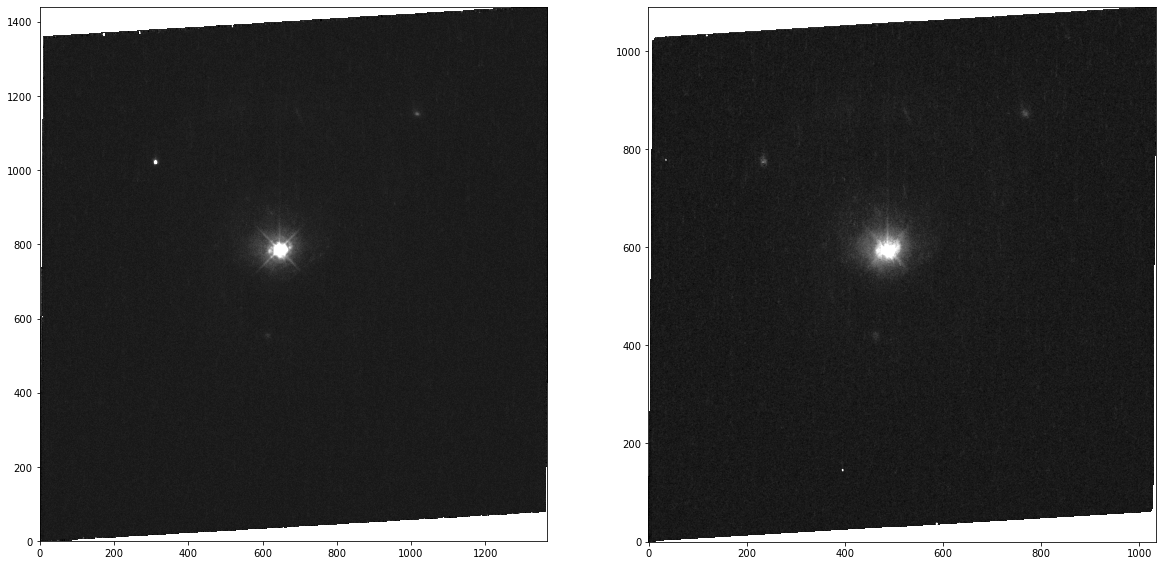

In [36]:
sci = fits.open(join(datapath,'{0}_src.fits'.format(instru)))['SCI', 1].data
scicons=fits.open('/data/xray/hst/s1/iby807020_drz.fits')['SCI', 1].data
wht = fits.open(join(datapath,'{0}_src.fits'.format(instru)))['WHT', 1].data
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(sci, vmin=-0.05, vmax=0.5, cmap='Greys_r', origin='lower')
ax2.imshow(scicons, vmin=-0.05, vmax=0.5, cmap='Greys_r', origin='lower')